# MNIST 数据集进行分类
## 数据集导入
使用Scikit-Learn中的 `sklearn.datasets.fetch_openml` 进行数据读取. 可以下载的数据集可以在开放数据集网址 www.openml.org 上找到.

下载的数据集位于 `〜/ scikit_learn_data`，加载的数据集具有字典的结构，加载速度太慢可以使用本地打开方式（推荐）：

直接到 [OpenML - mnist_784](https://www.openml.org/search?type=data&status=active&id=554) 中下载数据集，然后发下下载下来的格式是 `.arff`，可以使用 `scipy.io.arff.loadarff` 打开，然后将数据集中第0个用DataFrame打开即可看到数据集.

In [4]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

In [309]:
from scipy.io.arff import loadarff
import pandas as pd

mnist = loadarff('C:/Users/yy/scikit_learn_data/openml/mnist_784.arff')
df = pd.DataFrame(mnist[0])
df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'4'
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'9'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'2'
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'3'
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'4'
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'


数据集转化，将上述表格划分为数据集与验证集，需要注意的是：由于标签是字符串，所以转化后的结果还需要进一步转化数据格式.

In [310]:
import numpy as np
x, y = df.values[:, :-1].astype(np.float32) / 255, df.values[:, -1].astype(np.uint8)
train_x, test_x, train_y, test_y = x[:60000], x[60000:], y[:60000], y[60000:]
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


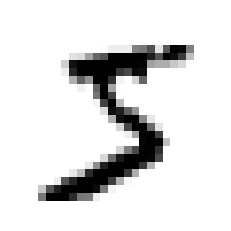

标签: 5


In [311]:
# 显示一张图片
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_x, sample_y = x[0], y[0]
sample_x_figure = sample_x.reshape((28, 28))

plt.imshow(sample_x_figure, cmap='binary')
plt.axis('off')
plt.show()
print("标签:", sample_y)

In [312]:
train_x[:10].shape

(10, 784)

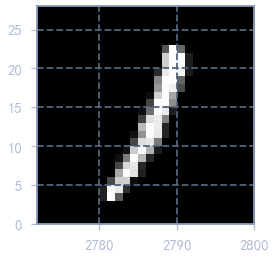

In [314]:
import matplotlib.pyplot as plt
import numpy as np

images = train_x[:100]
# 重构图像矩阵
images = images.reshape(-1, 28, 28)

# 遍历每张图像，并使用imshow绘制
for i in range(100):
    plt.imshow(images[i], cmap='gray', extent=[i*28, (i+1)*28, 0, 28])

# 展示画布
plt.show()

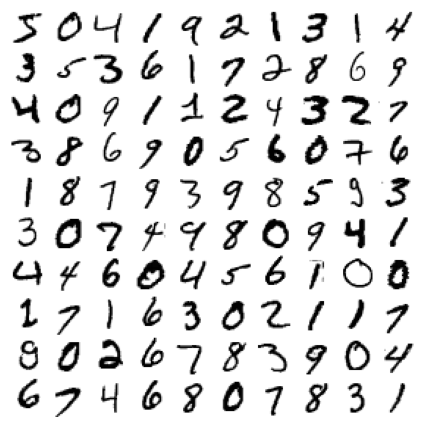

In [23]:
def plot_figures(instances, images_per_row=10, **options):
    # 图像大小
    size = 28
    # 每行显示的图像，取图像总数和每行预设值的较小值
    images_per_row = min(len(instances), images_per_row)
    # 总共的行数，下行等价于 ceil(len(instances) / image_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    # 如果有空余位置没有填充，用空白进行填充
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros([n_empty, size * size])], axis=0)
    # 将图像排列成网格
    image_grid = padded_instances.reshape([n_rows, images_per_row, size, size])
    # 使用np.transpose对图像网格进行重新排序，并拉伸成一张大图像用于绘制
    big_image = image_grid.transpose([0, 2, 1, 3]).reshape([n_rows * size, images_per_row * size])
    plt.imshow(big_image, cmap='binary', **options)
    plt.axis('off')
    plt.tight_layout()
plt.figure(figsize=(6, 6))
plot_figures(train_x[:100])
plt.savefig('figure/MNIST前100张图像')
plt.show()

## 训练二元分类器

先从简单的问题开始，如何分类一张图片是5还不是5. 可以使用随机梯度下降优化的线性分类器 `SGDClassifier`.

In [5]:
from sklearn.linear_model import SGDClassifier

train_y_5 = (train_y == 5)
test_y_5 = (test_y == 5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_x, train_y_5)

SGDClassifier(random_state=42)

In [6]:
print("简单预测一个样例:", sgd_clf.predict([sample_x]))

简单预测一个样例: [ True]


## 评估性能
### K-折交叉验证
下面使用 `sklearn.model_selection.StratifiedKFold` 实现自定义的交叉验证，使用方法和 `cross_val_score()` 类似，只不过这里将折叠数参数记为 `n_splits`（默认为5）.

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_idx, test_idx in skfolds.split(train_x, train_y_5):
    clone_clf = clone(sgd_clf)  # 每次新创建一个模型
    train_x_folds = train_x[train_idx]
    train_y_folds = train_y_5[train_idx]
    test_x_folds = train_x[test_idx]
    test_y_folds = train_y_5[test_idx]
    
    clone_clf.fit(train_x_folds, train_y_folds)
    pred = clone_clf.predict(test_x_folds)
    accuracy = sum(pred == test_y_folds)
    print(accuracy / len(pred))  # 输出准确率

0.97305
0.97465
0.9731


In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_x, train_y_5, cv=3, scoring='accuracy')

array([0.9748, 0.9657, 0.9692])

In [9]:
print("全部非5图像的占比:", sum(~train_y_5) / len(train_y))

全部非5图像的占比: 0.90965


使用交叉验证效果感觉不错，但是其实如果一个分类器将所有图像都判断为非5，其实就可以达到90.9%的正确率，所以上述分类结果没有很强的说服力，下面使用混淆矩阵进一步说明结果.

### 混淆矩阵

混淆矩阵的列是真实值，行是预测值，$(i,j)$ 处的值表示真实值为 $i$ 时，模型预测结果为 $j$ 的个数.

使用 `sklearn.metrics.confusion_matrix(true_y, pred_y)` 可以很容易地获得混淆矩阵. 而获得预测值的很好的一个方法是通过交叉验证返回的预测结果 `sklearn.model_selection.cross_val_predict`. 由于只使用了训练集，使用交叉验证可以保证将训练集进一步划分为更小的训练集与验证集，保证了预测的干净（预测数据没有再训练中出现）

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

train_y_pred = cross_val_predict(sgd_clf, train_x, train_y_5, cv=3)
confusion_matrix(train_y_5, train_y_pred)

array([[53613,   966],
       [  840,  4581]], dtype=int64)

#### 定义
在二分类的混淆矩阵的每个元素都有对应的名称：假设真实值与预测结果的列表排列均为 `[假, 真]`，则每个位置的元素对应名称如下所示：

- `(1,1)` 表示真负类(TN).
- `(1,2)` 表示假正类(FP).
- `(2,1)` 表示假负类(FN).
- `(2,2)` 表示真正类(TP).


> 记忆方法非常简单，名称中第一个“真与假”表示是否预测正确，第二个“正与负”表示预测结果的类别.

有两个常用参数：
$$
\text{精度} = \frac{TP}{TP+FP}\qquad \text{召回率} = \frac{TP}{TP+FN}
$$

- **精度(Precision)**：预测结果是真的时候，有多大概率是对的.
- **召回率(Recall)**：标签为真的时候，能有多大的概率预测对.（如果用假设检验的第一类错误来理解，设原假设为样本标签为真，那么“1-召回率”就是第一类错误）

一种评估精度与召回率的方法是 $F_1$ 参数（两者的调和平均数）：
$$
F_1 = \frac{2}{\frac{1}{\text{精度}}+\frac{1}{\text{召回率}}}
$$

用法：使用F1一般是希望精度与召回率同时较高时所用，但是对于特定问题，可能仅需要某一种参数越高越好. 例如检测小偷，肯定希望召回率越高越好，也就是所谓的“宁可错杀一千，不可放过一个”；而视频筛选中，希望精度越高越好，因为我们希望即使错筛了很多好的视频，但是留下来的都是好的就行.

**精度-召回率曲线**：模型通过得分是否超过阈值判断样本属于的类别，通过设定不同的阈值，从而可以得到不同的PR值，绘制出的曲线，一般称为P-R曲线，一般也用P-R曲线与x轴围成的面积(Area Under Curve, AUC)评估模型好坏（越大越好），面积计算可以使用 `sklearn.metrics.auc`.

#### 实现
Scikit-Learn中可以很容易地计算出精度，召回率和 $F_1$ 参数，分别为 `sklearn.metrics` 中的 `precision_score, recall_score, f1_score`，代入预测值与真实值即可计算出结果.

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("精度:", precision_score(train_y_5, train_y_pred))
print("召回率:", recall_score(train_y_5, train_y_pred))
print("F1:", f1_score(train_y_5, train_y_pred))

精度: 0.8258518117901569
召回率: 0.8450470392916436
F1: 0.8353391684901532


##### PR曲线
`SGD` 模型输出的是对样本的打分，而判断是否属于哪类则是通过阈值来确定的，默认阈值为 `0`，对于二分类问题，阈值与召回率成负相关关系（因为如果将所有都预测为真，则召回率一定很好），我们可以根据不同的阈值从而获得不同的预测结果，对应不同的模型，从而绘制出精度与召回率的关系图.

首先需要求出模型对每个样本的打分，还是用过 `cross_val_predict` 获得，但是这里需要从模型的 `decision_function` 获得评分，而不是最后的预测结果，使用 `method` 可以选择最后模型输出的函数，默认为 `method='predict'`.

最后使用 [`sklearn.metrics.precision_recall_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) 不同阈值下的精度与召回率的值，使用方法为 

- `precision_recall_curve(y_true, probas_pred)`，第一个参数为标签真实值，第二个参数为所有可能的得分. 于是阈值会根据全部得分从小到大逐一选择，并求出对应精度与召回率. 返回值：精度，召回率，阈值.

> 注意：精度和召回率的维数为 `(n_thresholds + 1,)` 比阈值大1，精度最后一个元素为 `1`，而召回率最后一个元素为 `0`，绘图时记得将其删去.

In [12]:
# 使用decision_function获得样本的打分
sgd_clf.decision_function(train_x[:10])

array([ 0.49010364, -5.79399718, -8.1066338 , -4.37994204, -4.7884292 ,
       -4.57067767, -4.47894354, -5.7897907 , -2.49371734, -3.34911346])

In [13]:
from sklearn.metrics import precision_recall_curve

train_y_scores = cross_val_predict(sgd_clf, train_x, train_y_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(train_y_5, train_y_scores)

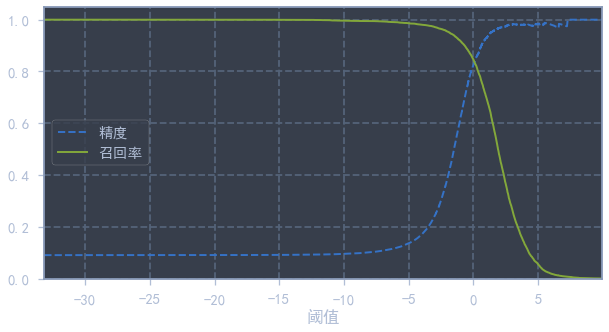

In [14]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="精度")
    plt.plot(thresholds, recalls[:-1], "g-", label="召回率")
    plt.legend()
    plt.xlabel("阈值")
    plt.axis([thresholds.min(), thresholds.max(), 0, 1.05])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [15]:
recall_for_90_precision = recalls[np.argmax(precisions >= 0.90)]  # 利用np.argmax可以找到第一个true的下标

曲线下面积为: 0.8907556859354993


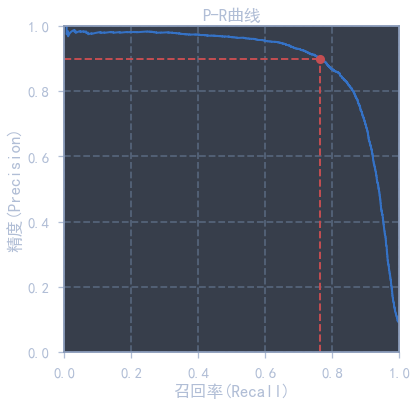

In [16]:
from sklearn.metrics import auc

def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(6, 6))
    plt.plot(recalls, precisions, 'b-', lw=2)
    plt.xlabel('召回率(Recall)')
    plt.ylabel('精度(Precision)')
    plt.axis([0, 1, 0, 1])
    plt.title('P-R曲线')
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_for_90_precision, recall_for_90_precision], [0, 0.9], 'r--')
plt.plot([0, recall_for_90_precision], [0.9, 0.9], 'r--')
plt.plot([recall_for_90_precision], [0.9], 'ro')
print("曲线下面积为:", auc(recalls, precisions))

##### ROC曲线

另一种常用的曲线称为 **受试者工作特征曲线(Receiver Operating Characteristic Curve, ROC)**，绘制的是真正类率（召回率）和假正类率（FPR），它们的定义如下
$$
\text{假正类率FPR} = \frac{FP}{TN+FP},\qquad \textbf{真负类率TPR(特异度)} = 1-FPR = \frac{TN}{TN+FP}
$$
不难发现，这种什么率就是按照混淆矩阵的行占比来定义的，例如上述两个FPR和TPR就分别是**全部负类样本中**被错误预测的概率的和被正确预测的概率，特别的TPR还被称为**特异度**.

实际使用中，我们会直接画出ROC曲线，然后用曲线下面积AUC来评判模型的好坏.

使用 [`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) 获得 `fpr, tpr, theresholds` 对应结果（与 `precision_recall_curve` 曲线返回值相同）

> 注：由于有 `drop_intermediatebool=True` 参数，会自动舍弃一些次优阈值，使得曲线显示更加清晰，所以返回结果中阈值个数可能远小于输入的样本个数.

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(train_y_5, train_y_scores)
print("ROC得分:", roc_auc_score(train_y_5, train_y_scores))

ROC得分: 0.970452271342763


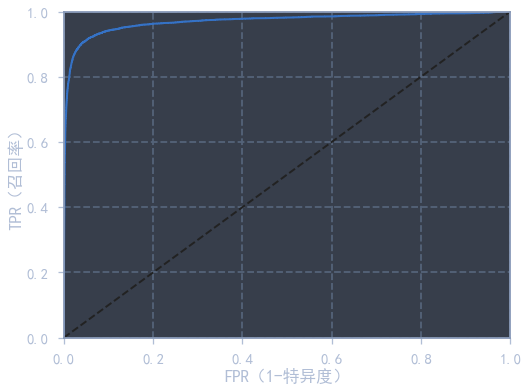

ROC得分: 0.970452271342763


In [18]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR（1-特异度）')
    plt.ylabel('TPR（召回率）')
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label='SGD')
plt.savefig("./figure/ROC曲线")
plt.show()
print("ROC得分:", auc(fpr, tpr))

使用随机森林 `RandomForestClassifier` 与 `SGD` 进行对比实验. 在随机森林模型中，打分是根据概率分布得到的，使用 `.predict_proba()` 可以得到样本对应的标签概率分布率，然后做正例列的切片即可得到得分.

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, train_x, train_y_5, cv=3, method='predict_proba')

In [20]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_y_5, y_scores_forest)
print("随机森林ROC评分:", roc_auc_score(train_y_5, y_scores_forest))  # 从得分可以明显看出，随机森林的二分类效果好于SGD

随机森林ROC评分: 0.9983400347444625


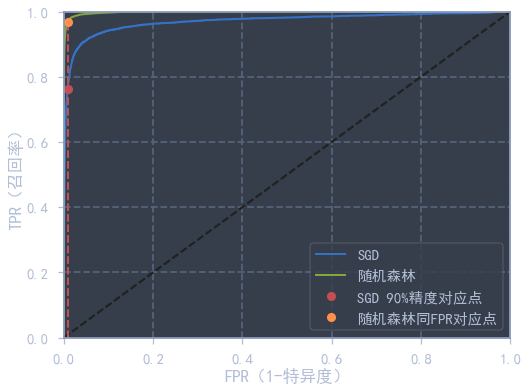

In [21]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='随机森林')
fpr_for_90_percision_sgd = fpr[np.argmax(tpr >= recall_for_90_precision)]
tpr_for_sgd_fpr_forest = tpr_forest[np.argmax(fpr_forest >= fpr_for_90_percision_sgd)]
plt.plot([fpr_for_90_percision_sgd, fpr_for_90_percision_sgd], [0, recall_for_90_precision], 'r--', lw=2)
plt.plot([0, fpr_for_90_percision_sgd], [recall_for_90_precision, recall_for_90_precision], 'r--', lw=2)
plt.plot([fpr_for_90_percision_sgd], [recall_for_90_precision], 'ro', label='SGD 90%精度对应点')
plt.plot([fpr_for_90_percision_sgd, fpr_for_90_percision_sgd], [0, tpr_for_sgd_fpr_forest], 'r--', lw=2)
plt.plot([0, fpr_for_90_percision_sgd], [tpr_for_sgd_fpr_forest, tpr_for_sgd_fpr_forest], 'r--', lw=2)
plt.plot([fpr_for_90_percision_sgd], [tpr_for_sgd_fpr_forest], 'yo', label='随机森林同FPR对应点')
plt.legend()
plt.show()

## 多类分类器
一些严格的二元分类器（SVM，线性分类器）也可以用于分类，有以下两种策略可以通过多个二元分类器实现多分类的目的：（例如创建一个模型将数字图像分类为0到9）

1. 一对多(One vs Rest)：训练10个二元分类器，每种数字一个，用于区分是或不是该数字，例如一个分类器用于划分是数字0或不是数字0，最后取最高的分类器对特定数字的决策分数作为整个模型的预测结果.

2. 一对一(One vs One)：训练 $\binom{2}{10}=45$ 个二元分类器，每个分类器用于区分两种数字，例如区分0和1,0和2,1和2等等. 每个分类器得到一个预测结果，最后通过判断哪个类获胜最多作为模型的预测结果.

In [24]:
# SVM二分类器默认为OvO多分类策略
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(train_x, train_y)

SVC()

In [32]:
# 使用OvR策略22.8min
from sklearn.multiclass import OneVsRestClassifier
svm_clf_ovr = OneVsRestClassifier(SVC(), verbose=2)
svm_clf_ovr.fit(train_x, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 22.8min finished


OneVsRestClassifier(estimator=SVC(), verbose=2)

In [39]:
# SGD多分类默认使用OvR策略
sgd_clf = SGDClassifier()
sgd_clf.fit(train_x, train_y)

SGDClassifier()

In [40]:
cross_val_score(sgd_clf, train_x, train_y, cv=3, scoring='accuracy')

array([0.9069 , 0.9061 , 0.90995])

In [43]:
# 使用SVM在测试集上的正确率竟然有98%！！！
from sklearn.metrics import accuracy_score
accuracy_score(test_y, svm_clf_ovr.predict(test_x))

0.98

In [44]:
accuracy_score(test_y, svm_clf.predict(test_x))

0.9792

In [46]:
# 保存一下模型
import joblib
joblib.dump(svm_clf_ovr, 'svm_ovr_mnist.pkl')

['svm_ovr_mnist.pkl']

## 误差分析

利用混淆矩阵进行多分类的误差分析，使用 `plt.matshow()` 对混淆矩阵进行可视化，在按每行除以对应标签总样本数目，再将对角线上值置为0，即可获得每种类别分类的错误率了.

In [82]:
train_y_pred = cross_val_predict(sgd_clf, train_x, train_y, cv=3)
confuse_matrix = confusion_matrix(train_y, train_y_pred)
confuse_matrix

array([[5743,    2,   20,   12,   16,   44,   39,   10,   32,    5],
       [   2, 6463,   53,   22,    9,   43,   15,   18,  103,   14],
       [  49,   33, 5328,   93,   87,   47,   88,   73,  136,   24],
       [  35,   16,  185, 5325,   12,  288,   28,   62,  110,   70],
       [  19,   16,   28,   14, 5413,   14,   49,   18,   67,  204],
       [  61,   13,   42,  173,   68, 4792,   85,   30,   98,   59],
       [  47,   12,   50,    4,   45,  125, 5599,    4,   28,    4],
       [  23,   22,   68,   29,   77,   20,    4, 5830,   23,  169],
       [  60,   92,   98,  186,   67,  340,   53,   33, 4832,   90],
       [  42,   16,   24,  113,  222,   84,    2,  215,   66, 5165]],
      dtype=int64)

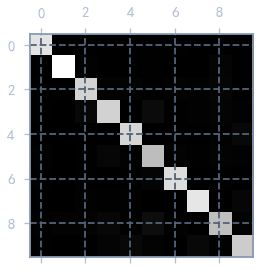

In [98]:
plt.matshow(confuse_matrix, cmap='gray')
plt.show()

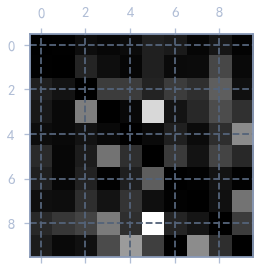

In [84]:
row_sums = conf_mx.sum(axis=1)
norm_confuse_matrix = confuse_matrix / row_sums
np.fill_diagonal(norm_confuse_matrix, 0)
plt.matshow(norm_confuse_matrix, cmap='gray')
plt.show()  # 可以看出，3很容易被分类成5

通过上面的混淆矩阵可以看出，3很容易被识别成5，下面我们来看看3与5的混淆矩阵中的部分图像.

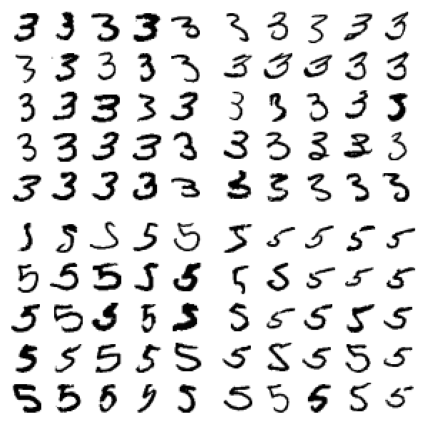

In [95]:
cl_a, cl_b = 3, 5  # class a and class b
aa_x = train_x[(train_y == cl_a) & (train_y_pred == cl_a)]
ab_x = train_x[(train_y == cl_a) & (train_y_pred == cl_b)]
ba_x = train_x[(train_y == cl_b) & (train_y_pred == cl_a)]
bb_x = train_x[(train_y == cl_b) & (train_y_pred == cl_b)]
plt.figure(figsize=(6, 6))
plt.subplot(221); plot_figures(aa_x[:25], images_per_row=5)
plt.subplot(222); plot_figures(ab_x[:25], images_per_row=5)
plt.subplot(223); plot_figures(ba_x[:25], images_per_row=5)
plt.subplot(224); plot_figures(bb_x[:25], images_per_row=5)
plt.savefig('figure/混淆矩阵实例图')
plt.show()

## 多输出分类
使用K近邻对图像进行降噪处理.

In [34]:
# 生成随机噪声图像
import numpy as np
np.random.seed(42)
noise = np.random.randint(0, 100, (len(train_x), 784)) / 255
train_x_modify = train_x + noise
noise = np.random.randint(0, 100, (len(test_x), 784)) / 255
test_x_modify = test_x + noise
train_y_modify = train_x
test_y_modify = test_x

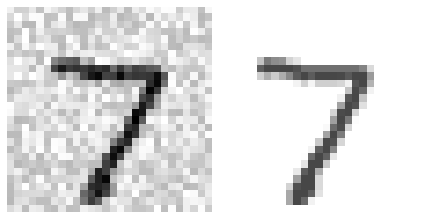

In [35]:
plot_figures([test_x_modify[0], test_y_modify[0]])

In [37]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(train_x_modify, train_y_modify)

KNeighborsRegressor()

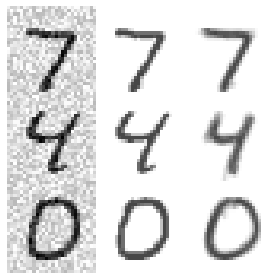

In [54]:
some_idx = [0, 6, 10]
sample_x_modify = test_x_modify[some_idx]
sample_y_modify = test_y_modify[some_idx]

plt.figure(figsize=(4, 4))
clean_image = knn_reg.predict(sample_x_modify)
plot_figures(np.concatenate([(sample_x_modify[i], sample_y_modify[i], clean_image[i]) for i in range(len(some_idx))]), images_per_row=3)
plt.savefig('figure/MNIST降噪效果')
plt.show()

# 练习题

## 1.在测试集上达到97%正确率

使用 `sklearn.neighbors.KNeighborsClassifier` 获得MNIST数据集在测试集上超过 $97\%$ 的正确率. 通过对 `weights, n_neighbors` 进行网格搜素度.

- `n_neighbors` 默认值为 $5$，表示分类的个数.
- `weights` 表示每个类中点对质心权重的计算方法：`uniform` 权重全部为1, `distance` 权重与到质心距离的反比相关.

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
params_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': list(range(5, 11))},
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, params_grid, cv=5, scoring='accuracy', verbose=2, error_score='raise')
grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................n_neighbors=5, weights=uniform; total time=  22.4s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  21.2s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  22.0s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  23.4s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  24.7s
[CV] END ....................n_neighbors=5, weights=distance; total time=  25.8s
[CV] END ....................n_neighbors=5, weights=distance; total time=  20.5s
[CV] END ....................n_neighbors=5, weights=distance; total time=  20.4s
[CV] END ....................n_neighbors=5, weights=distance; total time=  21.6s
[CV] END ....................n_neighbors=5, weights=distance; total time=  22.5s
[CV] END .....................n_neighbors=6, weights=uniform; total time=  23.4s
[CV] END .....................n_neighbors=6, wei

GridSearchCV(cv=5, error_score='raise', estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=2)

In [62]:
from sklearn.metrics import accuracy_score
print("最佳参数:", grid_search.best_params_)
print("最佳准确率:", grid_search.best_score_)
best_knn_clf = grid_search.best_estimator_
test_predict = best_knn_clf.predict(test_x)
print("测试集准确率:", accuracy_score(test_y, test_predict))

最佳参数: {'n_neighbors': 6, 'weights': 'distance'}
最佳准确率: 0.9712333333333334
测试集准确率: 0.9709


## 2. 数据增强
通过对原式数据集进行一个上下左右一个像素的平移后，对模型进行训练.

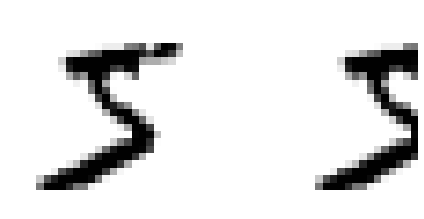

In [71]:
from scipy.ndimage.interpolation import shift

def shift_image(image_vector, direction):
    image = image_vector.reshape(28, 28)
    shift_image = shift(image, direction, cval=0)
    return shift_image.reshape(-1)

sample_x_shifted = shift_image(train_x[0], [0, 10])
plot_figures([train_x[0], sample_x_shifted])

In [91]:
def shift_image_dataset(dataset, direction):
    dataset_shifted = np.apply_along_axis(func1d=shift_image, axis=1, arr=dataset, direction=direction)
    return dataset_shifted

train_x_shifted = train_x.copy()
train_y_shifted = train_y.copy()
for direction in ([0, 1], [0, -1], [1, 0], [-1, 0]):
    train_x_shifted = np.concatenate([train_x_shifted, shift_image_dataset(train_x, direction)], axis=0)
    train_y_shifted = np.concatenate([train_y_shifted, train_y], axis=0)
print(train_x_shifted.shape, train_y_shifted.shape)

(300000, 784) (300000,)


In [98]:
# 用时约为2min，可以看到正确率提高了0.7%
from sklearn.model_selection import cross_val_score
knn_clf= KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(train_x_shifted, train_y_shifted)
print('测试集准确率:', accuracy_score(test_y, knn_clf.predict(test_x)))

测试集准确率: 0.9772


## 预测titanic数据集

通过船员信息判断是否能够生还. 数据集下载 [kaggle - Titanic](https://www.kaggle.com/competitions/titanic/data)，保存到目录 `./dataset/titanic/` 下，由于该数据为比赛数据，完整测试集可在 [kaggle - Titanic dataset](https://www.kaggle.com/datasets/brendan45774/test-file) 下载.

In [105]:
import pandas as pd
train_df = pd.read_csv(r"./datasets/titanic/train.csv")
test_df = pd.read_csv(r"./datasets/titanic/test.csv")

In [106]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [243]:
# 划分特征与标签
train_x_df = train_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
test_x_df = test_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
train_y = train_df['Survived'].values
test_y = test_df['Survived'].values

In [231]:
train_x_df.info()  # Sex, Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [232]:
train_x_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


需要做的数据预处理：

数字
1. 处理缺失值，均值填充.
2. 标准化.

类别
1. `Sex` 转化为数字.
2. `Embarked` 处理缺失值，众数填充.
3. `Embarked` 转化为one-hot


In [233]:
# 处理数字
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_attributes = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
pipeline_num = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
])
pipeline_num.fit_transform(train_x_df[num_attributes]).shape

(891, 5)

In [234]:
# 处理类别
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

pipeline_cat_embarked = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
])
print(pipeline_cat_embarked.fit_transform(np.array(train_x_df['Embarked']).reshape(-1, 1)).shape)
print(pipeline_cat_embarked.named_steps['onehot_encoder'].categories_)

(891, 3)
[array(['C', 'Q', 'S'], dtype=object)]


In [251]:
from sklearn.compose import ColumnTransformer

pipeline_prepare = ColumnTransformer([
    ('num', pipeline_num, num_attributes),
    ('cat_embarked', pipeline_cat_embarked, ['Embarked']),
    ('cat_sex', OrdinalEncoder(), ['Sex'])
])
train_x = pipeline_prepare.fit_transform(train_x_df)
test_x = pipeline_prepare.transform(test_x_df)
column_names = num_attributes + ['Embarked_C', 'Embarked_Q', 'Embarked_S'] + ['Sex']

In [252]:
# 处理过后的数据集
train_x_df_prepared = pd.DataFrame(train_x, columns=column_names)
train_x_df_prepared

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.0,0.0,1.0,1.0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,1.0,0.0,0.0,0.0
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,0.0,0.0,1.0,0.0
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,0.0,0.0,1.0,0.0
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
886,-0.369365,-0.207709,-0.474545,-0.473674,-0.386671,0.0,0.0,1.0,1.0
887,-1.566107,-0.823344,-0.474545,-0.473674,-0.044381,0.0,0.0,1.0,0.0
888,0.827377,0.000000,0.432793,2.008933,-0.176263,0.0,0.0,1.0,0.0
889,-1.566107,-0.284663,-0.474545,-0.473674,-0.044381,1.0,0.0,0.0,1.0


In [253]:
train_x_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [265]:
# K近邻
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': list(range(5, 10))},
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, params_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(train_x, train_y)
print("最高正确率", grid_search.best_score_)
print("最佳参数:", grid_search.best_params_)

最高正确率 0.7968614650681063
最佳参数: {'n_neighbors': 9, 'weights': 'uniform'}


In [285]:
from sklearn.metrics import accuracy_score

def predict_accuracy(model):
    return accuracy_score(test_y, model.predict(test_x))
print('测试集正确率:', predict_accuracy(grid_search.best_estimator_))

测试集正确率: 0.8349282296650717


In [291]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(train_x, train_y)
forest_scores = cross_val_score(forest_clf, train_x, train_y, cv=10, scoring='accuracy')
print("随机森林平均得分:", forest_scores.mean())
print("测试集正确率:", predict_accuracy(forest_clf))

随机森林平均得分: 0.8182397003745319
测试集正确率: 0.8229665071770335


In [292]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(train_x, train_y)
svm_scores = cross_val_score(svm_clf, train_x, train_y, cv=10, scoring='accuracy')
print("随机森林平均得分:", svm_scores.mean())
print("测试集正确率:", predict_accuracy(svm_clf))

随机森林平均得分: 0.8226966292134831
测试集正确率: 0.9354066985645934


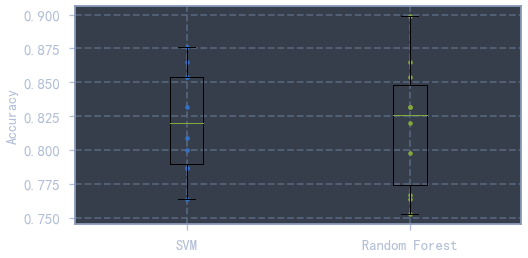

In [293]:
# 使用箱型图显示模型分类的准确率分布
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

## 4. 垃圾邮件分类器
从[Apache SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/)中下载数据集，`ham` 是正常邮件，`spam` 是垃圾邮件.

In [9]:
from pathlib import Path
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"  # 下载源的根路径
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"  # 下载文件的url链接
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = Path.cwd().joinpath("datasets/spam")  # 本地保存路径

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):  # 自义下载函数
    spam_path.mkdir(parents=True, exist_ok=True)  # 若文件夹不存在，创建文件夹
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):  # 设定保存的文件名和对应的url
        path = spam_path.joinpath(filename)  # 文件保存的位置
        if not path.exists():  # 若文件以存在，则不重复下载
            urllib.request.urlretrieve(url, path)  # 文件下载
        tar_bz2_file = tarfile.open(path)  # 创建解压tarfile实例
        tar_bz2_file.extractall(path=spam_path)  # 解压文件到指定目录下
        tar_bz2_file.close()  # 关闭解压实例

In [10]:
fetch_spam_data()

In [111]:
import re
import fnmatch
# 载入邮件
HAM_DIR = SPAM_PATH.joinpath('easy_ham')
SPAM_DIR = SPAM_PATH.joinpath('spam')
ham_filenames = list(HAM_DIR.glob("[0-9]*"))  # 由于样本中必定包含数字，所以通过通配符可以很容易找出来（不是正则表达式）
spam_filenames = list(SPAM_DIR.glob("[0-9]*"))
print("正常邮件个数:", len(ham_filenames))
print("垃圾邮件个数:", len(spam_filenames))

正常邮件个数: 2500
垃圾邮件个数: 500


In [113]:
with open(HAM_DIR.joinpath(ham_filenames[0])) as file:
    print(file.read())

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [131]:
# 使用email库处理这些邮件(处理标题，编码等等)
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(spam_path.joinpath(directory + '/' + filename.name), 'rb') as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)

In [132]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [145]:
ham_emails[0].get_content().strip()

'Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.cs.mu

In [149]:
spam_emails[6].get_content().strip()

'Help wanted.  We are a 14 year old fortune 500 company, that is\ngrowing at a tremendous rate.  We are looking for individuals who\nwant to work from home.\n\nThis is an opportunity to make an excellent income.  No experience\nis required.  We will train you.\n\nSo if you are looking to be employed from home with a career that has\nvast opportunities, then go:\n\nhttp://www.basetel.com/wealthnow\n\nWe are looking for energetic and self motivated people.  If that is you\nthan click on the link and fill out the form, and one of our\nemployement specialist will contact you.\n\nTo be removed from our link simple go to:\n\nhttp://www.basetel.com/remove.html\n\n\n4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40'

后面的步骤非常复杂，就不继续完成了，大致要完成网址处理，html格式处理(BeautifulSoup)，文本单词出现次数统计(NLTK)，最终将文本转化为词向量，训练模型. 完整可参考 https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb